# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
# TODO: Import any packages that you might need
import os
import json
from tqdm import tqdm

from PIL import Image
from os import listdir

import random
import shutil

import os.path
import sagemaker
import boto3

from sagemaker.pytorch import PyTorch

In [3]:
BUCKET = 'mlnd-capstone-inventory-monitoring'
ROLE = sagemaker.get_execution_role()
ROLE

'arn:aws:iam::572821218814:role/service-role/AmazonSageMaker-ExecutionRole-20230331T142377'

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:29<00:00, 13.68it/s]


100%|██████████| 2299/2299 [02:59<00:00, 12.77it/s]


100%|██████████| 2666/2666 [03:30<00:00, 12.65it/s]


100%|██████████| 2373/2373 [03:12<00:00, 12.36it/s]


100%|██████████| 1875/1875 [02:30<00:00, 12.46it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [26]:
# Resize Image (224 x 224)
def resize_image():    
    input_dir = "./train_data"
    output_dir = "./resized_data/"
    size = (224, 224)  # desired size of the output images
    os.makedirs(output_dir, exist_ok=True)

    for file_path in os.listdir(input_dir):
        os.makedirs(os.path.join(output_dir, file_path), exist_ok=True)
        filePath = os.path.join(input_dir, file_path)
        for file_name in os.listdir(filePath):
            if os.path.isfile(os.path.join(input_dir, file_path, file_name)):
                image_path = os.path.join(input_dir, file_path, file_name)
                resized_image_path = os.path.join(output_dir, file_path, file_name)
                
                with Image.open(image_path) as img:
                    img = img.resize(size, Image.Resampling.BILINEAR)
                    img.save(resized_image_path)
                
resize_image()

In [40]:
#TODO: Perform any data cleaning or data preprocessing
def split_dataset():
    # Define the path to the original dataset
    original_dataset_dir = r'./resized_data'

    # Define the path to the directory where you want to store the split dataset
    base_dir = 'splited_dataset'

    # Define the name of the directories for the training, validation and test sets
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'valid')
    test_dir = os.path.join(base_dir, 'test')

    # Define the list of classes in the dataset
    class_names = ["1", "2", "3", "4", "5"]

    # Set the ratio of the split (80/10/10)
    train_ratio = 0.8
    validation_ratio = 0.1
    test_ratio = 0.1

    # Create the directories for the training, validation, and test sets
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class and copy the images to the appropriate directory
    for class_name in class_names:
        class_dir = os.path.join(original_dataset_dir, class_name)
        file_names = os.listdir(class_dir)
        random.shuffle(file_names)
        num_files = len(file_names)
        num_train_files = int(num_files * train_ratio)
        num_validation_files = int(num_files * validation_ratio)
        num_test_files = num_files - num_train_files - num_validation_files

        # Create subdirectories for each class in the training, validation, and test sets
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Copy files to the training set
        train_files = file_names[:num_train_files]
        for file_name in train_files:
            src = os.path.join(class_dir, file_name)
            dst = os.path.join(train_dir, class_name, file_name)
            shutil.copyfile(src, dst)

        # Copy files to the validation set
        validation_files = file_names[num_train_files:num_train_files+num_validation_files]
        for file_name in validation_files:
            src = os.path.join(class_dir, file_name)
            dst = os.path.join(validation_dir, class_name, file_name)
            shutil.copyfile(src, dst)

        # Copy files to the test set
        test_files = file_names[-num_test_files:]
        for file_name in test_files:
            src = os.path.join(class_dir, file_name)
            dst = os.path.join(test_dir, class_name, file_name)
            shutil.copyfile(src, dst)
            
split_dataset()

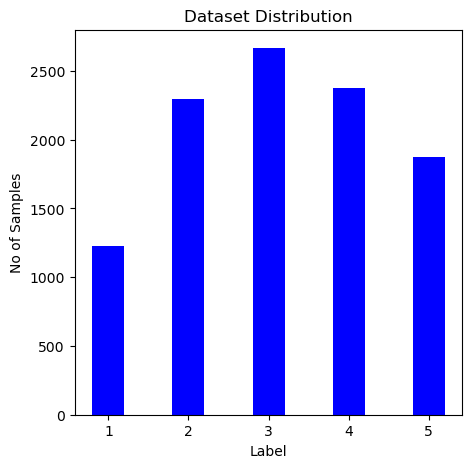

In [7]:
#dataset_count = [1228,2299, 2666, 2373,1875]

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'1':1228, '2':2299, '3':2666,'4':2373, '5':1875}
object_count = list(data.keys())
no_of_samples = list(data.values())

fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(object_count, no_of_samples, color ='blue',width = 0.4)

plt.xlabel("Label")
plt.ylabel("No of Samples")
plt.title("Dataset Distribution")
plt.show()

In [41]:
%%capture
#TODO: Upload the data to AWS S3
!aws s3 cp splited_dataset s3://{BUCKET}/data/ --recursive

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [47]:
#TODO: Declare your model training hyperparameter.
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [48]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    source_dir="scripts",
    entry_point="hpo.py",
    base_job_name='pytorch-amazon-bin-image-classification-hpo',
    role=ROLE,
    framework_version="1.9", # 1.4.0
    instance_count=1,
    instance_type="ml.p2.xlarge", #You can use GPU instance ml.p2.xlarge or standard instance ml.m5.large or local
    py_version='py38' # py3
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=1,
    base_tuning_job_name = 'pytorch-amazon-bin-image-classification-hpo-tuning',
    objective_type=objective_type
)

In [49]:
os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/data'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'

tuner.fit({"training": f"s3://{BUCKET}/data"}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [50]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-amazon-bin-i-230411-1352',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:572821218814:hyper-parameter-tuning-job/pytorch-amazon-bin-i-230411-1352',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 5,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"', '"256"', '"512"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_

In [51]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimeter_hpo = best_estimator.hyperparameters()

best_estimeter_hpo


2023-04-11 14:10:38 Starting - Found matching resource for reuse
2023-04-11 14:10:38 Downloading - Downloading input data
2023-04-11 14:10:38 Training - Training image download completed. Training in progress.
2023-04-11 14:10:38 Uploading - Uploading generated training model
2023-04-11 14:10:38 Completed - Resource reused by training job: pytorch-amazon-bin-i-230411-1352-003-74e80d18


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.0030902876106215765',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-amazon-bin-image-classification-2023-04-11-13-52-59-535"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-572821218814/pytorch-amazon-bin-image-classification-2023-04-11-13-52-59-535/source/sourcedir.tar.gz"'}

In [52]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-amazon-bin-i-230411-1352'

In [53]:
tuner.analytics().dataframe()

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",0.095766,pytorch-amazon-bin-i-230411-1352-005-d9c13399,Completed,1.577532,2023-04-11 14:21:08+00:00,2023-04-11 14:25:56+00:00,288.0
1,"""128""",0.004369,pytorch-amazon-bin-i-230411-1352-004-87c06c8c,Completed,1.462447,2023-04-11 14:15:55+00:00,2023-04-11 14:20:42+00:00,287.0
2,"""32""",0.069287,pytorch-amazon-bin-i-230411-1352-003-74e80d18,Completed,1.584646,2023-04-11 14:10:40+00:00,2023-04-11 14:15:28+00:00,288.0
3,"""64""",0.003090,pytorch-amazon-bin-i-230411-1352-002-ef8e74b7,Completed,1.426203,2023-04-11 14:05:26+00:00,2023-04-11 14:10:08+00:00,282.0
4,"""128""",0.008581,pytorch-amazon-bin-i-230411-1352-001-34bba7f3,Completed,1.517349,2023-04-11 13:54:55+00:00,2023-04-11 14:04:24+00:00,569.0


In [54]:
# Best hyperparameters found:
hyperparameters = {"batch_size": int(best_estimeter_hpo['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimeter_hpo['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.0030902876106215765'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [34]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "213",
        "eval.save_interval": "31",
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [57]:
# TODO: Create and fit an estimator
# TODO: Create and fit an estimator
#hyperparameters = {'batch_size': 64, 'learning_rate': '0.0030902876106215765'}

estimator =  PyTorch( # TODO: Your estimator here
    source_dir="scripts",
    entry_point="train.py",
    base_job_name="pytorch-amazon-bin-image-classification",
    role=ROLE,
    instance_count=1,
    instance_type="ml.p2.xlarge", 
    framework_version='1.9',
    py_version='py38',
    hyperparameters=hyperparameters,
    output_path=f"s3://{BUCKET}/output/",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({"training": f"s3://{BUCKET}/data/"}, wait=False)# TODO: Your estimator here

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184


In [8]:
# If kernel dies, how to continue from a completed training job
estimator = PyTorch.attach("pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184")


2023-04-11 15:24:08 Starting - Preparing the instances for training
2023-04-11 15:24:08 Downloading - Downloading input data
2023-04-11 15:24:08 Training - Training image download completed. Training in progress.
2023-04-11 15:24:08 Uploading - Uploading generated training model
2023-04-11 15:24:08 Completed - Training job completed


In [58]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184

latest_job_debugger_artifacts_path : s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/debug-output

rule_output_path : s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/rule-output



In [59]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-11 15:29:29.335 ip-172-16-29-240.ec2.internal:6507 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-11 15:29:29.358 ip-172-16-29-240.ec2.internal:6507 INFO s3_trial.py:42] Loading trial debug-output at path s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/debug-output


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


INFO:matplotlib.font_manager:generated new fontManager


[2023-04-11 15:30:03.881 ip-172-16-29-240.ec2.internal:6507 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-11 15:30:04.905 ip-172-16-29-240.ec2.internal:6507 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


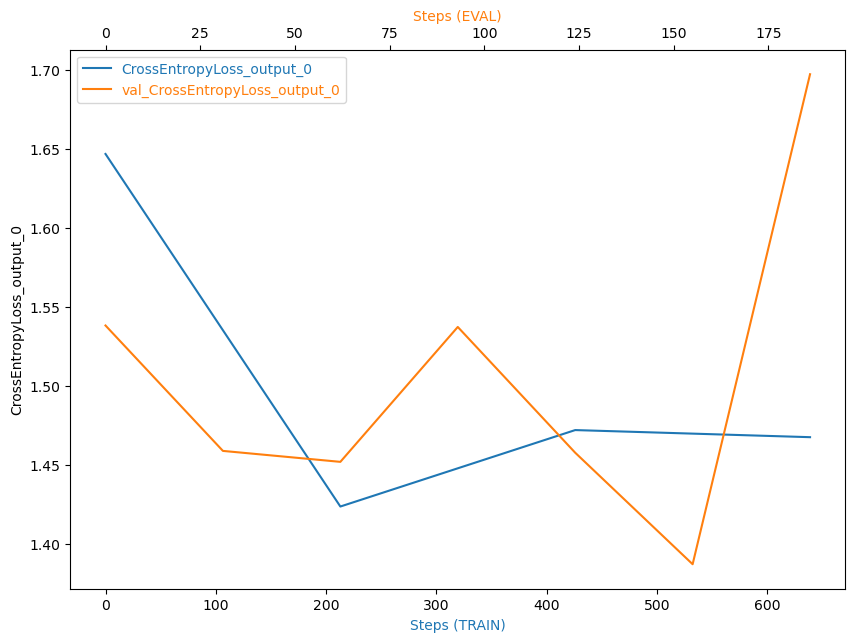

In [60]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [63]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [64]:
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/rule-output
download: s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://mlnd-capstone-inventory-monitoring/output/pytorch-amazon-bin-image-classification-2023-04-11-15-06-30-184/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://mlnd-caps

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [9]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io
import base64

In [13]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [14]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            source_dir="scripts",
            role=ROLE,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [15]:
predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
) # TODO: Add your deployment configuration like instance type and number of instances

------!

In [16]:
predictor.endpoint_name

'pytorch-inference-2023-04-15-09-57-52-754'

In [46]:
classes = [1, 2, 3, 4, 5]

In [47]:
# TODO: Run an prediction on the endpoint
import numpy as np
def prob(x):
    return np.exp(x) / np.sum(np.exp(x))

# with open("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "rb") as image:
#     f = image.read()
#     img_bytes = bytearray(f)

# Image.open(io.BytesIO(img_bytes))

def predict(path):
    #request_dict={ "url": url }
    with open(path, "rb") as image:
        f = image.read()
        img_bytes = bytearray(f)
        
    response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
    display(Image.open(io.BytesIO(img_bytes)))
    logits = np.array(response[0])
    print(logits)
    predicted_index = np.argmax(logits)
    print(f"Identify Bin: {classes[predicted_index]}")
    print(f"Probability: {prob(logits)[predicted_index]}")

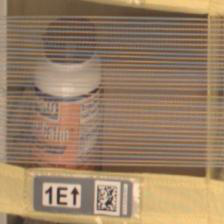

[-0.83754432  0.43038726  0.68645942  0.89606053  0.41697329]
Identify Bin: 4
Probability: 0.30915581088540456


In [52]:
predict("./splited_dataset/test/3/01138.jpg")

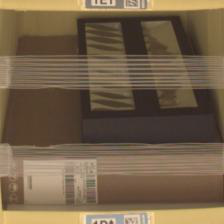

[ 0.36589158  1.07819462  0.58115435  0.15872678 -0.74548155]
Identify Bin: 2
Probability: 0.37608065466256047


In [53]:
predict("./splited_dataset/test/2/00558.jpg")

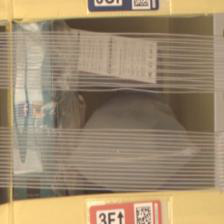

[-1.1615442   0.5032106   0.83094192  1.23454177  0.65755761]
Identify Bin: 4
Probability: 0.3569080068692551


In [55]:
predict("./splited_dataset/test/4/00387.jpg")

In [56]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-15-09-57-52-754
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-15-09-57-52-754


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [6]:
%%capture
#TODO: Upload the data to AWS S3 that will be used by the EC2 Instance to train.
!aws s3 cp amazon_bin_image.zip s3://{BUCKET}/EC2/

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [32]:
hyperparameters = {'batch_size': 64, 'learning_rate': '0.0030902876106215765'}

In [38]:
# TODO: Train your model on Multiple Instances
###in this cell, create and fit an estimator using multi-instance training
estimator_multi_instance = PyTorch(
    source_dir="scripts",
    entry_point="train.py",
    base_job_name='pytorch-multi-instance-amazon-multi-instance-bin-image-classification',
    role=ROLE,
    instance_count=4,
    instance_type='ml.m5.2xlarge',
    framework_version='1.9',
    py_version='py38',
    hyperparameters=hyperparameters,
    output_path=f"s3://{BUCKET}/output_multi_instance/",
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [39]:
estimator_multi_instance.fit({"training": f"s3://{BUCKET}/data"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-multi-instance-amazon-multi-ins-2023-04-15-11-35-23-746


2023-04-15 11:35:24 Starting - Starting the training job...
2023-04-15 11:35:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-15 11:36:52 Downloading - Downloading input data......
2023-04-15 11:37:52 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-15 11:37:46,044 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-15 11:37:46,046 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-15 11:37:46,054 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-15 11:37:46,056 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-15 11:37:46,233 sagem